# PyTorch: GAN (Generative Adverserial Network)

- There are two neural networks: a Generator and a Discriminator.
- The generator generates a "fake" sample given a random vector/matrix frfom a dataset
- The discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator).
- We train the discriminator for a few epochs, then train the generator for a few epochs, and repeat.

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='dataset/', train=True, download=True, transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [2]:
img, label = mnist[0]
print('label', label)
print('max', torch.max(img).item(), 'min', torch.min(img).item())

label 5
max 1.0 min -1.0


In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [4]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Label: 5')

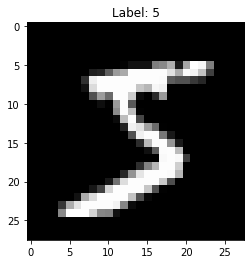

In [5]:
img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
plt.title('Label: ' + str(label))

In [6]:
from torch.utils.data.dataloader import DataLoader

In [7]:
batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

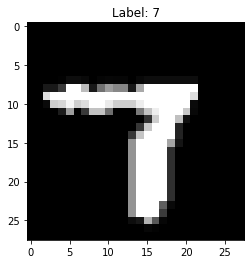

In [8]:
for img_batch, label_batch in data_loader:
    plt.imshow(img_batch[10][0], cmap='gray')
    plt.title('Label: ' + str(label_batch[10].item()))
    break

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
image_size = 28 * 28
hidden_size = 256

In [11]:
import torch.nn as nn

### Discriminator:

In [12]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

In [13]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

### Generator:

In [14]:
latent_size = 64

In [15]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

In [16]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28, 28)).detach())

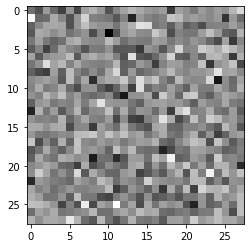

In [17]:
plt.imshow(gen_imgs[0], cmap='gray')

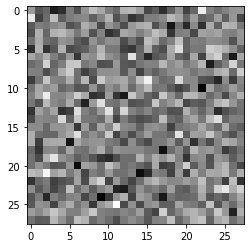

In [18]:
plt.imshow(gen_imgs[1], cmap='gray')

In [19]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

### Discriminator Training

- We use *Binary Cross Entropy* as loss function
- We expect the discriminator to output **1** if the image was picked from the **real** MNIST dataset, and **0** if it was **generated**.
- We first pass a batch of real images, and compute the loss, setting the target labels to 1.
- Then, we generate a batch of fake images using the generator, pass them into the discriminator, and compute the loss, setting the target labels to 0.
- Finally we add the two losses and use the **overall loss to perform gradient descent** to adjust the weights of the discriminator.
- It's important to note that we **don't change** the weights of the **generator** model in this step (`d_optimizer` only affects the `D.parameters()`)

In [20]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [21]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [22]:
def train_discriminator(images):
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = d_loss_real + d_loss_fake
    
    reset_grad()
    
    d_loss.backward()
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

### Generator Training

- We generate a batch of images using the generator.
- Then we pass them into the discriminator.
- We calculate the loss by setting the **target labels to 1** i.e. real.
- We do this because the generator's **objective** is to *fool the discriminator*.
- We use this loss to perform gradient descent.

In [23]:
def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    reset_grad()
    
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

### Model Training

Create a directory to store generated images

In [24]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Save a batch of real images that we can use for comparision

In [25]:
from IPython.display import Image
from torchvision.utils import save_image

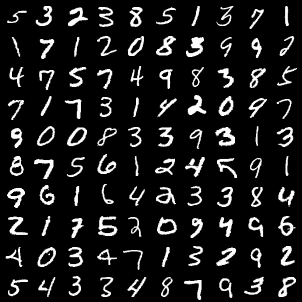

In [26]:
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


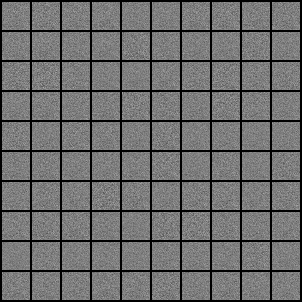

In [27]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [28]:
num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

In [29]:
%%time

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    save_fake_images(epoch + 1)

Epoch [0/300], Step [200/600], d_loss: 0.0285, g_loss: 4.2538, D(x): 1.00, D(G(z)): 0.02
Epoch [0/300], Step [400/600], d_loss: 0.0216, g_loss: 6.2664, D(x): 0.99, D(G(z)): 0.01
Epoch [0/300], Step [600/600], d_loss: 0.0655, g_loss: 5.6068, D(x): 0.98, D(G(z)): 0.05
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0569, g_loss: 4.6817, D(x): 0.99, D(G(z)): 0.04
Epoch [1/300], Step [400/600], d_loss: 0.4789, g_loss: 4.0753, D(x): 0.82, D(G(z)): 0.11
Epoch [1/300], Step [600/600], d_loss: 0.1222, g_loss: 5.4155, D(x): 0.95, D(G(z)): 0.04
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.2802, g_loss: 3.6744, D(x): 0.94, D(G(z)): 0.17
Epoch [2/300], Step [400/600], d_loss: 0.5167, g_loss: 4.7164, D(x): 0.90, D(G(z)): 0.21
Epoch [2/300], Step [600/600], d_loss: 0.4558, g_loss: 3.0352, D(x): 0.83, D(G(z)): 0.13
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.8003, g_loss: 4.3029, D(x): 0.88, D(G(z)): 0.30
Epoch [3/300], Step [400/6

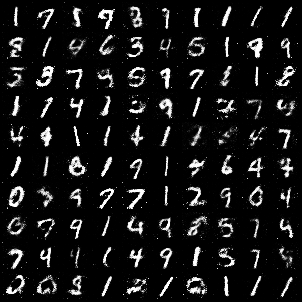

In [30]:
Image('./samples/fake_images-0100.png')

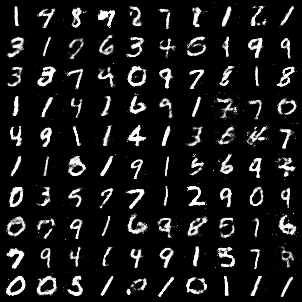

In [31]:
Image('./samples/fake_images-0200.png')

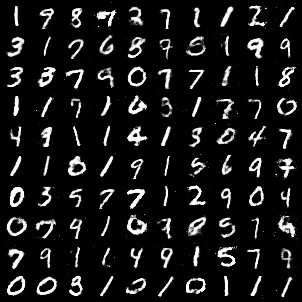

In [32]:
Image('./samples/fake_images-0300.png')

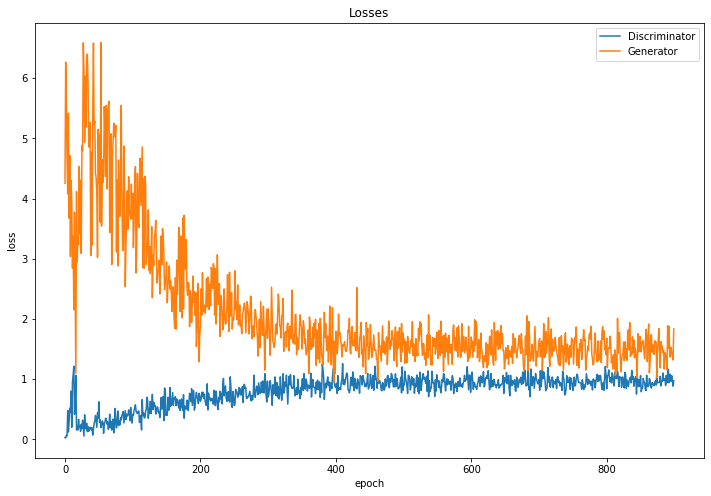

In [33]:
plt.figure(figsize=(12, 8))
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

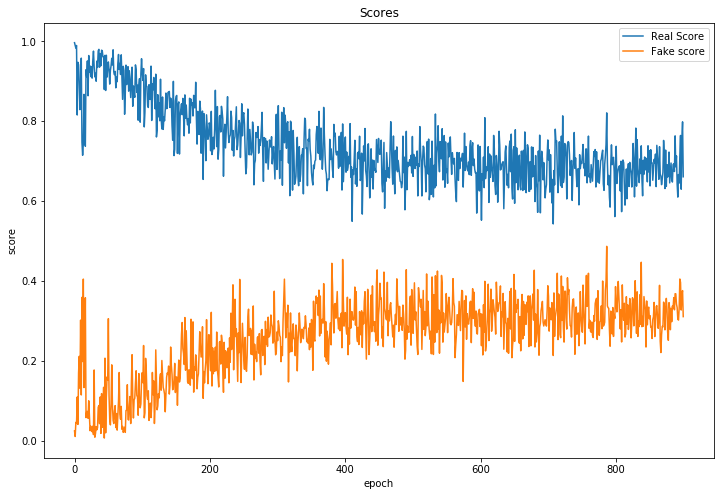

In [34]:
plt.figure(figsize=(12, 8))
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [35]:
torch.save(G.state_dict(), 'models/G.ckpt')
torch.save(D.state_dict(), 'models/D.ckpt')